In [1]:
#NN Surrogate model class
from injector_surrogate_quads import *
import physics_gp

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#Pytorch 
import numpy as np
import torch
import gpytorch
import botorch 

import matplotlib.pyplot as plt

/Users/conniexu/opt/anaconda3/envs/baxenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Model = Surrogate_NN(pytorch=True)

Model.load_saved_model(model_path = '../models/', 
                       model_name = 'Surrogate_NN_PyTorch')

Model.load_scaling(scalerfilex = '../data/transformer_x_pytorch.pth', 
                   scalerfiley = '../data/transformer_y_pytorch.pth')
Model.take_log_out = False

In [3]:
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
print(twiss0['x'], twiss0['y'])

[1e-06, 1.113081026, -0.0689403587] [1e-06, 1.113021659, -0.07029489754]


In [4]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]

bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

In [5]:
def evaluate(config): 
    """
    D is input space dimensionality
    N is number of sample points
    :param config: input values of opt_var_names, torch.tensor, shape (N, D) 
    returns (N, 1) 
    """
    N = config.shape[0]
    D = config.shape[1]
    
    # make input array of length model_in_list (inputs model takes)
    x_in = torch.empty((N,len(Model.model_in_list)))
    
    # fill in reference point around which to optimize
    x_in[:,:] = torch.tensor(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    col = []
    for i in range(D):
        col.append(Model.loc_in[opt_var_names[i]]) #should make col a flat list of indices, e.g. [4, 6, 7]
    x_in[:, col] = config[:,:] 
    
    #output predictions
    y_out = Model.pred_machine_units(x_in)

    return -1*objective(y_out)


def objective(y_out):
    """
    :param y_out: tensor with has a shape of (N, num_outputs)
    returns tensor of emittance * bmag for each input, shape (N, 1)
    """
    
    # geometric emittance in transverse plane
    out1 = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = torch.sqrt(out1 * out2)
  
    sigma_x = y_out[:,Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:,Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x = torch.tensor(alpha0_x).repeat(y_out.shape[0])
    alpha_y = torch.tensor(alpha0_y).repeat(y_out.shape[0])
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * torch.sqrt(beta0_x / beta_x) - alpha0_x * torch.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * torch.sqrt(beta0_y / beta_y) - alpha0_y * torch.sqrt(beta_y / beta0_y))**2)
    bmag = torch.sqrt(bmag_x * bmag_y)
    
    out = (emit * bmag)/1e-6 # in um units 
    return out.reshape(-1,1)

In [6]:
n_var = 9 
class NN3_prior(nn.Module):
    def __init__(self):
        super(NN3_prior, self).__init__()
        
        hidden_size = 20
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 
    
class NN4_prior(nn.Module):
    def __init__(self):
        super(NN4_prior, self).__init__()
        
        hidden_size = 30
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 
    
class NN5_prior(nn.Module):
    def __init__(self):
        super(NN5_prior, self).__init__()
        
        hidden_size = 40
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 

## Correlation Plots between NN custom prior mean and Surrogate (real value)

model3_1hidden_20nodes_500epoch_0.02 and surrogate: 0.5422923564910889
model4_3hidden_30nodes_500epoch_0.01 and surrogate: 0.8843661546707153


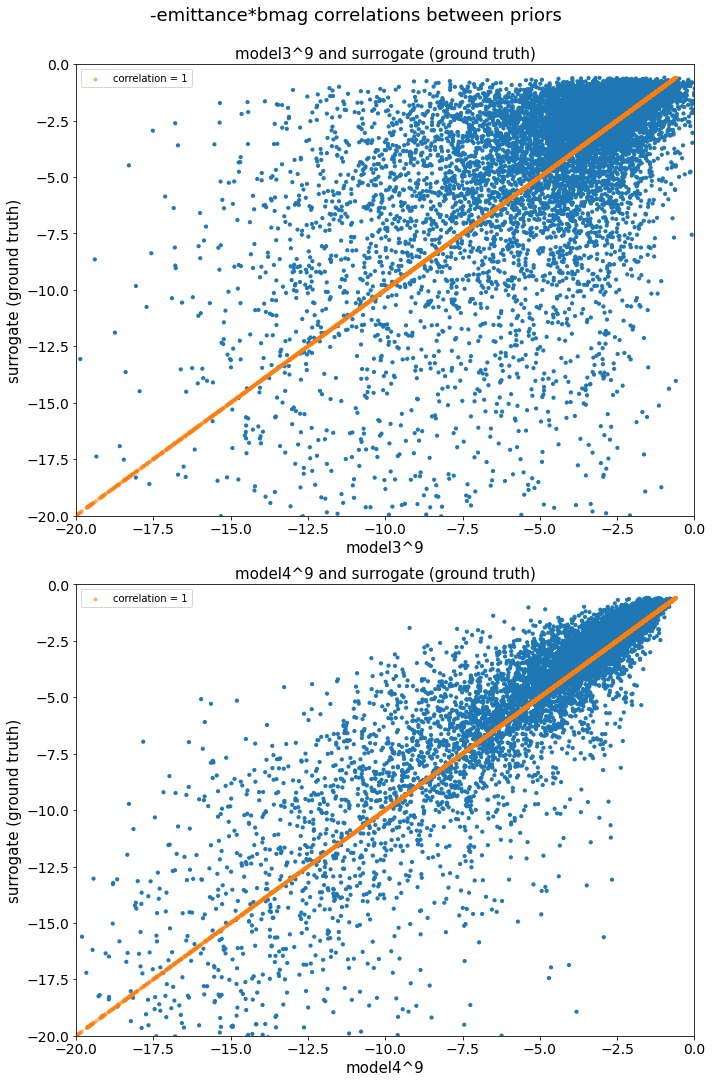

In [10]:
NN_names = ['model3_1hidden_20nodes_500epoch_0.02', 
            'model4_3hidden_30nodes_500epoch_0.01']
NN_priors = [NN3_prior(), NN4_prior()] 
NN_data = ['3^9', '4^9', '5^9']

NN_transformers = []
for i in range(len(NN_names)):
    NN_transformer = botorch.models.transforms.input.Normalize(1)
    NN_transformer.load_state_dict(torch.load('./results/transformer_y_' + NN_data[i] + '.pth'))
    NN_transformers.append(NN_transformer)

n_samples = 10000
cutoff_val = -20

# uniform samples 
x = torch.zeros((n_samples, n_var)) 
for i in range(n_var):
    x[:,i] = torch.tensor(np.random.uniform(bounds[i,0],bounds[i,1],(n_samples,)))

transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
normed_x = transformer_x(x)

real_y = evaluate(x).detach()

# plot histogram of output distribution
histogram = False
if histogram == True: 
    plot_y = real_y[torch.where(real_y > cutoff_val)]
    plt.xlabel('-emittance*bmag (mm-mrad)')
    plt.ylabel('number of samples')
    plt.hist(plot_y.numpy(), bins = 100)

# plot correlations between each entry in NN_names and the injector surrogate (ground truth)
fig, axes = plt.subplots(len(NN_names), 1, sharey=True)
fig.suptitle('-emittance*bmag correlations between priors', y = 1.0, fontsize=18)
fig.set_size_inches(10,15)

for i, ax in enumerate(fig.axes):
    NN_priors[i].load_state_dict(torch.load('./results/' + NN_names[i] + '.pth'))
    NN_priors[i].eval()

    # get NN's -emittance*bmag prediction (real value) 
    normed_NN_y = NN_priors[i](normed_x)
    NN_y = NN_transformers[i].untransform(normed_NN_y)
    
    ax.set_title(NN_names[i][:6] + '^9 and surrogate (ground truth)', fontsize = 15)
    ax.set_xlim([cutoff_val, 0.0])
    ax.set_ylim([cutoff_val, 0.0])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel(NN_names[i][:6]+'^9', fontsize = 15)
    ax.set_ylabel('surrogate (ground truth)', fontsize = 15)
    ax.scatter(NN_y.detach(), real_y.detach(), s=np.full(n_samples, 10))
    ax.scatter(real_y, real_y, s=np.full(n_samples, 10), alpha = 0.50, label='correlation = 1')
    ax.legend()
    
    # calculate numerical correlation with output values in a certain range 
    NN_y = NN_y[torch.where(real_y > cutoff_val)[0]] 
    processed_y = real_y[torch.where(real_y > cutoff_val)[0]]
    y = [NN_y.squeeze(), processed_y.squeeze()]
    y = torch.stack(y)
    corr = torch.corrcoef(y)
    print(f'{NN_names[i]} and surrogate: {corr[0,1]}')
    
fig.tight_layout()


### Correlation Plots Over Individual Parameters 

SOL1:
model3^9 and ground truth = 0.9613
model4^9 and ground truth = 0.9019
CQ01:
model3^9 and ground truth = 0.821
model4^9 and ground truth = 0.9259
SQ01:
model3^9 and ground truth = 0.9625
model4^9 and ground truth = 0.9806
QA01:
model3^9 and ground truth = 0.2652
model4^9 and ground truth = 0.8957
QA02:
model3^9 and ground truth = -0.07577
model4^9 and ground truth = 0.9393
QE01:
model3^9 and ground truth = 0.6572
model4^9 and ground truth = 0.8224
QE02:
model3^9 and ground truth = 0.3082
model4^9 and ground truth = 0.8389
QE03:
model3^9 and ground truth = -0.4274
model4^9 and ground truth = 0.9678
QE04:
model3^9 and ground truth = 0.8602
model4^9 and ground truth = 0.8873


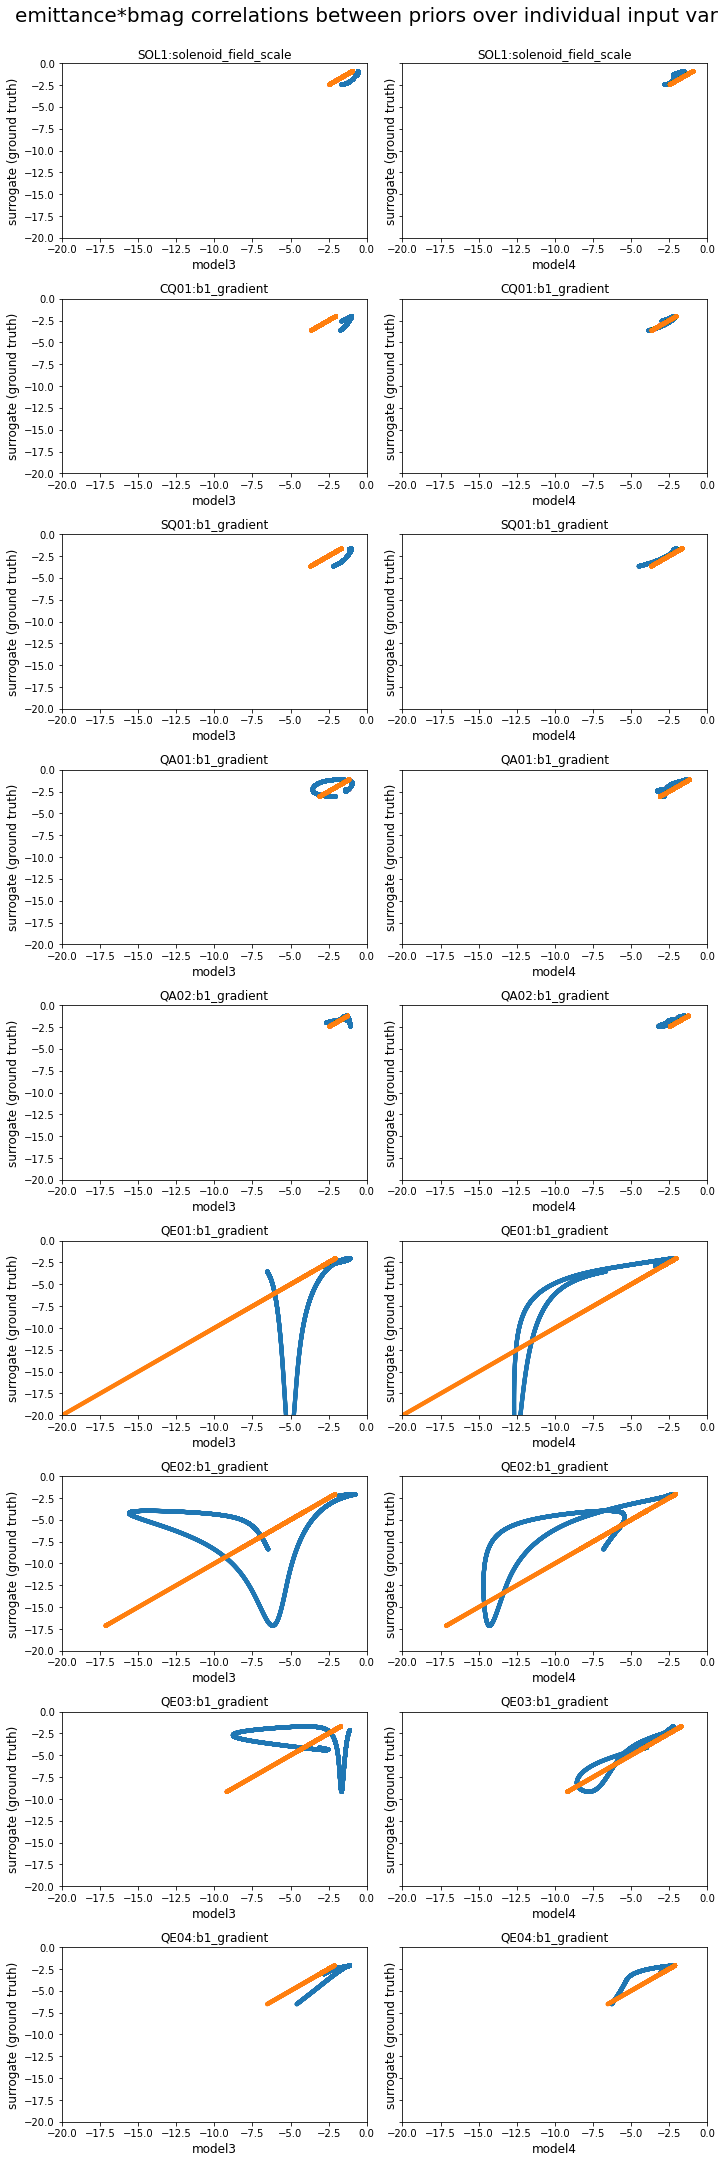

In [12]:
scan_ref_point = torch.cat([torch.as_tensor([ref_point[0][Model.loc_in[param_name]]]) for param_name in opt_var_names])
# adjust scan_ref_point as necessary
scan_ref_point[0] = 0.465
scan_ref_point[1] = -0.01
scan_ref_point[2] = -0.0
scan_ref_point[3] = -1.8
scan_ref_point[4] = 2.5
scan_ref_point[5] = -4.0
scan_ref_point[7] = 7.0
scan_ref_point[8] = -5.0

n_samples = 10000

def scan(model_param, num_scans, model_prior, NN_transformer_y):
    """
    scans values across a single parameter of the model, keeping others constant
    :param model_param: name of the model param that is being scanned, string, size 1 
    :param num_scans: number of values scanned for parameter 
    returns model_test_y, polynomial_test_y of all scanned values  
    """ 
    param_index = opt_var_names.index(model_param)
    
    test_x = scan_ref_point.repeat(num_scans, 1) 
    test_x[:,param_index] = torch.linspace(bounds[param_index, 0], bounds[param_index, 1], num_scans)
    
    model_test_y = evaluate(test_x.float()).detach()
    normed_prior_test_y = model_prior(transformer_x(test_x).float()).detach()
    prior_test_y = NN_transformer_y.untransform(normed_prior_test_y)
    
    return model_test_y, prior_test_y, test_x

s_size = 6
m_size = 12
l_size = 20

fig, axes = plt.subplots(len(opt_var_names), len(NN_names), sharey=True)
fig.suptitle('emittance*bmag correlations between priors over individual input var', fontsize = l_size, y= 1.0)
fig.set_size_inches(10,30)

for i, row in enumerate(axes):
    model_param = opt_var_names[i] 
    print(model_param[:5])
    for j, ax in enumerate(row):
        model_test_y, prior_test_y, test_x = scan(model_param, n_samples, NN_priors[j], NN_transformers[j])
        units = 'kG*m' if model_param == 'SOL1:solenoid_field_scale' else 'kG'
        
        ax.set_title(model_param)
        ax.set_xlabel(f'{NN_names[j][:6]}', fontsize=m_size)
        ax.set_xlim([cutoff_val, 0.0])
        ax.set_ylim([cutoff_val, 0.0])
        ax.set_ylabel('surrogate (ground truth)', fontsize=m_size)
        ax.scatter(prior_test_y, model_test_y, s=np.full(n_samples, 10))
        ax.scatter(model_test_y, model_test_y, s=np.full(n_samples, 10), alpha = 0.5)
        
        # calculate numerical correlation with output values in a certain range 
        model_test_y = model_test_y[torch.where(prior_test_y > cutoff_val)[0]] 
        prior_test_y = prior_test_y[torch.where(prior_test_y > cutoff_val)[0]]
        y = [prior_test_y.squeeze(), model_test_y.squeeze()]
        y = torch.stack(y)
        corr = torch.corrcoef(y)
        print(f'{NN_names[j][:6]}^9 and ground truth = {corr[0,1]:.4}')

fig.tight_layout()